# Data preparation for sequence models

Here we must transform previously recovered onset data into a format that can be fed into a RNN.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
%run ../../Utilities/Utilities.ipynb

Using TensorFlow backend.


In [46]:
data = pd.read_pickle("../../Data/Guitar/File_onset_data_corrected.pkl")

## Loading the waveform into the DataFrame

In [47]:
samples_path = "../../Samples/Guitar/Riffs/"

In [48]:
from tqdm import tqdm_notebook
tqdm_notebook().pandas()

In [49]:
data["x"] = data["File"].progress_apply(lambda x: waveform(samples_path + x).y)

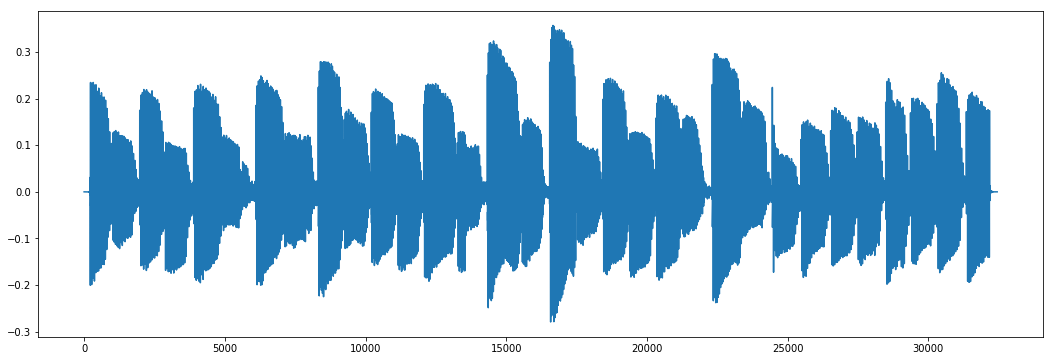

In [50]:
plt.figure(figsize=(18,6))
plt.plot(data["x"].sample().values[0])

## Creating the onset signal (target)

In [51]:
def create_onset_wave(x):
    onsets = x.loc["Onsets"]
    wave = x.loc["x"]
    y = np.zeros(int(wave.shape[0]/10))
    for onset in onsets:
        y[int(onset/10):int(onset/10)+20] = 1
    return y

In [52]:
data["y"] = data.apply(create_onset_wave, axis=1)

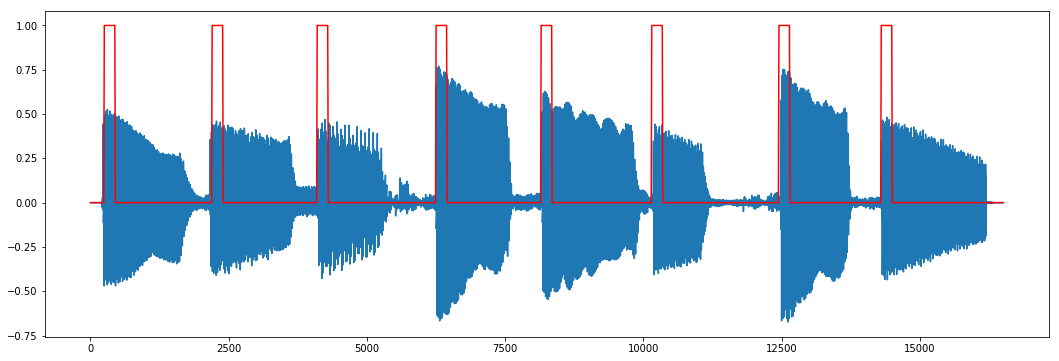

In [53]:
row = data.sample()
plt.figure(figsize=(18,6))
plt.plot(3 * row["x"].values[0])
plt.plot(np.arange(0, row["y"].values[0].shape[0]*10, 10), row["y"].values[0], "r")

In [54]:
data.to_pickle("../../Data/Guitar/File_onset_data_final.pkl")

## Padding both input and target waves to a uniform length

In [55]:
data = pd.read_pickle("../../Data/Guitar/File_onset_data_final.pkl")

In [56]:
(data["x"].apply(lambda x: x.shape[0])).max()

32449

In [57]:
max_length = 32500

In [58]:
def pad(seq, max_length):
    if seq.shape[0] < max_length:
        seq = np.append(seq, [0] * (max_length - seq.shape[0]))
    else:
        seq = seq[:max_length]
    return seq

In [60]:
data["x"] = data["x"].apply(lambda x: pad(x, max_length))
data["y"] = data["y"].apply(lambda x: pad(x, int(max_length/10)))

In [61]:
(data["x"].apply(lambda x: x.shape[0])).mean()

32500.0

In [62]:
(data["y"].apply(lambda x: x.shape[0])).mean()

3250.0

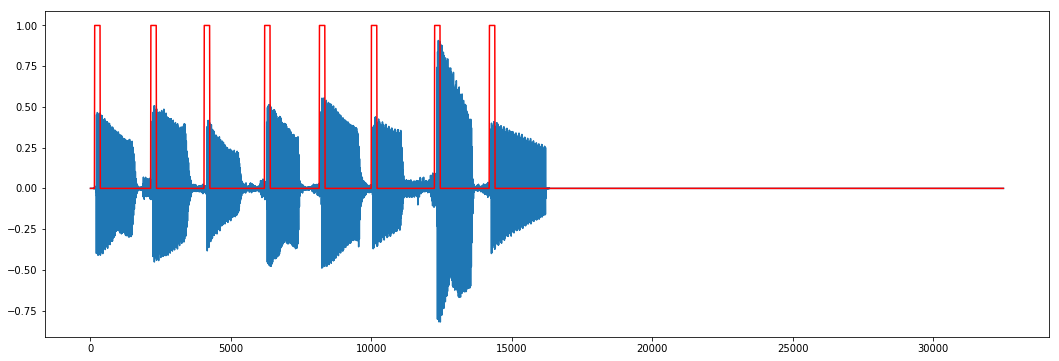

In [63]:
row = data.sample()
plt.figure(figsize=(18,6))
plt.plot(3 * row["x"].values[0])
plt.plot(np.arange(0, row["y"].values[0].shape[0]*10, 10), row["y"].values[0], "r")

In [64]:
data.to_pickle("../../Data/Guitar/File_onset_data_final.pkl")